# Import all relevant libraries

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import datetime
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Extracting the Dugong Dataset

The dataset was downloaded as a csv file from the [QLD open data portal](https://www.data.qld.gov.au/dataset/marine-strandings) and uploaded into the Jupyter notebook. 

Here we read the data 

In [2]:
dugong_df = pd.read_csv('dugong-strandings.csv')

Now remove all NaN values 

In [3]:
dugong = dugong_df[dugong_df['Location'].notna()]

Set the index to Location 

In [4]:
dugong.set_index('Location', inplace=True)

Now we can view the data

In [5]:
dugong

,2014,2013,2012,2011,2010
Location,,,,,
Moreton Bay,7,7,6,16,14
Hervey Bay,1,5,6,19,6
Rockhampton,1,2,8,10,3
Mackay,1,0,1,4,1
Townsville,2,3,4,51,16
Cairns,0,2,5,11,16
Remainder of east coast,11,8,14,55,12


# Extracting data from eReefs

Extracting the data directly from eReefs for analysis proved problematic due to the size of the dataset it created. To overcome this, we extracted our required variables to create a data array for each site, for each month across the desired years and saved them locally as a netCDF file. We then combined each month to create an array for each year at the sites, and then combined these again to create an array for each site across the years. These were also saved locally as a netCDF file for analysis. 

### Selecting a site and year to extract by defining the name, location and year e.g. the Hervey Bay site for the year 2011

Note: bb_res is a bounding box resolution, used to contain the min and max coordinates. Here it is used to extract the information on a 1° square around the site location.

In [6]:
siteName = 'HerveyBay'
siteLon =  125.7
siteLat = -25.2
year = 2011
bb_res = 1.

Setting extraction from eReefs Biogeochemical dataset

In [7]:
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"   


### Checking the depth (k value) to select for


We conducted a literature review and determined we would only require data for the depth up to 12m. We need to now determine the layers of k data we need to select for in our extraction which will allow us to analyse up to 12m. 


Due to the size of the data, we define a month to extract a little data as possible to determine the depth, k. We have already defined the year above

In [8]:
month_st = 1   # Starting month 
month_ed = 1   # Ending month 

Then, data for this month is extracted

In [9]:
biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
ds_bio = xr.open_mfdataset(biofiles, chunks={'time': '100MB'})

We will only need look at one variable from the data to determine this. For example, Temperature:

In [10]:
temp = ds_bio.temp
temp = temp.sel(method='nearest')

Here we check the depth to see what value of k we will be selecting for:

In [11]:
temp.zc.values[11:]

array([-12.75,  -8.8 ,  -5.55,  -3.  ,  -1.5 ,  -0.5 ])

From the above array, at index 11 the depth is 12.75 m so we will only take values from the last 6 layers.

### Extracting data for given region for an entire year for earch variable. 


Here we select data for the variables at 12m slices slice and then select only the dataset in the bounding box defined below.

Note: For Light Intensity Above Seagrass and Seagrass N, the depth is not a factor so there is no need to do the slicing process. For these, we only require to perform the bounding box code to extract the data for the site.

First, we need to create our bounding box to define the coordinates of the site and ensure we are extracting data only within for that site latitude and longitude for the site defined above. 

In [12]:
bounding_box = [siteLon-bb_res/2.,siteLat-bb_res/2.,siteLon+bb_res/2.,siteLat+bb_res/2.]

Here a function is created to extract each variable at the desired depth within the defined bounding box for each month. This can be easily done for each site by changing the site definitions above.

In [13]:
for k in range(1,13):

    print('Save dataset for month: ', k)
    biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(k, k+1)]

    ds_bio = xr.open_mfdataset(biofiles, chunks={'time': '100MB'})
    
# Selecting specific variables from eReefs

    TOTAL_NITROGEN = ds_bio.TOTAL_NITROGEN
    TOTAL_NITROGEN = TOTAL_NITROGEN.sel(method='nearest')
    temp = ds_bio.temp
    temp = temp.sel(method='nearest')
    salinity = ds_bio.salt
    salinity = salinity.sel(method='nearest')
    light = ds_bio.EpiPAR_sg
    light = light.sel(method='nearest')
    seagrass = ds_bio.SG_N
    seagrass = seagrass.sel(method='nearest')
    
# Selecting variables for the depth of 10m
    
    surf_TOTAL_NITROGEN = TOTAL_NITROGEN.sel(k=slice(11,-1))
    mask_lon3 = (surf_TOTAL_NITROGEN.longitude >= bounding_box[0]) & (surf_TOTAL_NITROGEN.longitude <= bounding_box[2])
    mask_lat3 = (surf_TOTAL_NITROGEN.latitude >= bounding_box[1]) & (surf_TOTAL_NITROGEN.latitude <= bounding_box[3])
    HerveyBay_TOTAL_NITROGEN = surf_TOTAL_NITROGEN.where(mask_lon3 & mask_lat3, drop=True)
    HerveyBay_TOTAL_NITROGEN_mean = HerveyBay_TOTAL_NITROGEN.mean(dim='k',skipna=True)
    
    surf_temp = temp.sel(k=slice(11,-1))
    mask_lon4 = (surf_temp.longitude >= bounding_box[0]) & (surf_temp.longitude <= bounding_box[2])
    mask_lat4 = (surf_temp.latitude >= bounding_box[1]) & (surf_temp.latitude <= bounding_box[3])
    HerveyBay_temp = surf_temp.where(mask_lon4 & mask_lat4, drop=True) 
    HerveyBay_temp_mean = HerveyBay_temp.mean(dim='k',skipna=True)
    
    surf_salinity = salinity.sel(k=slice(11,-1))
    mask_lon5 = (surf_salinity.longitude >= bounding_box[0]) & (surf_salinity.longitude <= bounding_box[2])
    mask_lat5 = (surf_salinity.latitude >= bounding_box[1]) & (surf_salinity.latitude <= bounding_box[3])
    HerveyBay_salinity = surf_salinity.where(mask_lon5 & mask_lat5, drop=True)
    HerveyBay_salinity_mean = HerveyBay_salinity.mean(dim='k',skipna=True)
    
    mask_lon6 = (light.longitude >= bounding_box[0]) & (light.longitude <= bounding_box[2])
    mask_lat6 = (light.latitude >= bounding_box[1]) & (light.latitude <= bounding_box[3])
    HerveyBay_light = light.where(mask_lon6 & mask_lat6, drop=True)
    
    mask_lon7 = (seagrass.longitude >= bounding_box[0]) & (seagrass.longitude <= bounding_box[2])
    mask_lat7 = (seagrass.latitude >= bounding_box[1]) & (seagrass.latitude <= bounding_box[3])
    HerveyBay_seagrass = seagrass.where(mask_lon7 & mask_lat7, drop=True) 
    
# Loading varibles into data array

    loadTOTAL_NITROGEN = HerveyBay_TOTAL_NITROGEN_mean.load()
    loadtemp = HerveyBay_temp_mean.load()
    loadsalinity = HerveyBay_salinity_mean.load()
    loadlight = HerveyBay_light.load()
    loadseagrass = HerveyBay_seagrass.load()
    
    site_ds = loadTOTAL_NITROGEN.to_dataset() 
    site_ds["temp"] = (['time', 'latitude', 'longitude'],  loadtemp.values) 
    site_ds["salinity"] = (['time', 'latitude', 'longitude'],  loadsalinity.values) 
    site_ds["light"] = (['time', 'latitude', 'longitude'],  loadlight.values) 
    site_ds["seagrass"] = (['time', 'latitude', 'longitude'],  loadseagrass.values) 
    
# Saving this as a netCDF file to a folder on the notebook called Hervey Bay
    
    site_ds.to_netcdf(siteName+'_'+str(k)+'_'+str(year)+'.nc')

Save dataset for month:  1
Save dataset for month:  2
Save dataset for month:  3
Save dataset for month:  4
Save dataset for month:  5
Save dataset for month:  6
Save dataset for month:  7
Save dataset for month:  8
Save dataset for month:  9
Save dataset for month:  10
Save dataset for month:  11
Save dataset for month:  12


Now there is a netCDF file for Hervey Bay 2011 for each month in a folder on the notebook called HerveyBay.

Here we combine each monthly netCDF file to create a data frame containing the data across the year and again save it as a netCDF file:

In [14]:
dsyear = xr.open_mfdataset('HerveyBay_*_2011.nc')

dsyear.to_netcdf('HerveyBay2011.nc')

Now we can define this as the sites name and year and visualise what has been created:

In [15]:
HerveyBay2011 = xr.open_dataset('HerveyBay2011.nc')
HerveyBay2011

<xarray.Dataset>
Dimensions:         (time: 365, latitude: 0, longitude: 0)
Coordinates:
  * time            (time) datetime64[ns] 2011-01-01T02:00:00 ... 2011-12-31T...
  * latitude        (latitude) float64 
  * longitude       (longitude) float64 
Data variables:
    TOTAL_NITROGEN  (time, latitude, longitude) float32 ...
    temp            (time, latitude, longitude) float32 ...
    salinity        (time, latitude, longitude) float32 ...
    light           (time, latitude, longitude) float32 ...
    seagrass        (time, latitude, longitude) float32 ...

From this dataset you can see that there are 5 data variables: Total Nitrogen, Temperature, Salinity, Light and Seagrass for the year 2011. 

This needs to be repeated for each year by changing the initial definitions.

Once all the years for a site have been completed, they can be combined into a single data frame: 

In [16]:
HerveyBay = xr.open_mfdataset('HerveyBay/HerveyBay*.nc')

HerveyBay

<xarray.Dataset>
Dimensions:         (time: 1461, latitude: 33, longitude: 34)
Coordinates:
  * time            (time) datetime64[ns] 2011-01-01T02:00:00 ... 2014-12-31T...
  * latitude        (latitude) float64 -25.79 -25.76 -25.73 ... -24.86 -24.83
  * longitude       (longitude) float64 152.3 152.3 152.4 ... 153.2 153.3 153.3
Data variables:
    TOTAL_NITROGEN  (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    temp            (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    salinity        (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    light           (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    seagrass        (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>

You can see this is a data array containing the desired variables across the years. This process needs to be completed for each site of interest by changing the inital definitions for site, longitude and latitude.

# Extracting the Cyclone Data

To extract cyclone data from the dataset that is relevant to our area of study, we first need to determine the relevant cyclone basin.  
The [metadata](https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf) of the [NOAA IBTrACS cyclones](https://www.ncdc.noaa.gov/ibtracs/index.php?name=ibtracs-data) dataset that we will use provides the following basin key:  

**Basin Key:**

* NA - North Atlantic
* EP - Eastern North Pacific
* WP - Western North Pacific
* NI - North Indian
* SI - South Indian
* SP - Southern Pacific
* SA - South Atlantic

Since the region we are exploring is the GBR, we will be looking at the cyclones of the Southern Pacific (SP) basin.

The following is the code to load the CSV file of the [NOAA IBTrACS cyclones](https://www.ncdc.noaa.gov/ibtracs/index.php?name=ibtracs-data) dataset for the South Pacific basin:

In [17]:
#url = https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.SP.list.v04r00.csv
url = 'ibtracs.SP.list.v04r00.csv'
df = pd.read_csv(url, parse_dates=['ISO_TIME'], usecols=range(12), index_col='SID',
                 skiprows=[1], na_values=[' ', 'NOT_NAMED'],
                 keep_default_na=False, dtype={'NAME': str})
df

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
1897005S10135,1897,1,SP,EA,NaN,1897-01-04 12:00:00,NR,-10.1000,135.300,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-04 15:00:00,NR,-10.2755,134.902,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-04 18:00:00,NR,-10.4406,134.523,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-04 21:00:00,NR,-10.5853,134.182,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-05 00:00:00,NR,-10.7000,133.900,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022139S15169,2022,27,SP,MM,GINA,2022-05-21 18:00:00,NR,-20.6000,171.100,NaN,NaN
2022139S15169,2022,27,SP,MM,GINA,2022-05-21 21:00:00,NR,-20.5147,171.309,NaN,NaN
2022139S15169,2022,27,SP,MM,GINA,2022-05-22 00:00:00,NR,-20.5000,171.500,NaN,NaN


At this stage, we will not remove the NaN values as this will also remove tracking information that we will use to plot each cyclone's movement.

In [18]:
df.nunique() # Returns the number of unique values for each column

SEASON        124
NUMBER        135
BASIN           2
SUBBASIN        3
NAME          430
ISO_TIME    58393
NATURE          6
LAT         49696
LON         42297
WMO_WIND       32
WMO_PRES      110
dtype: int64

Performing *df.nunique()* reveals that the dataset does not just consist of SP basin data – it also includes data from the South Indian (SI) basin which we will need to filter out.  

Before we remove the SI basin data from the dataset, we will narrow down the dates to the relevant range for our study. Since our dugong stranding and variable datasets range from the beginning of 2011 to the end of 2014, we will be focusing on the cyclones that occured during this period.

In [19]:
# Keep only the rows that satisfy the specified date range
df2 = df[df["ISO_TIME"].between('2011-01-01','2014-12-31')]

# Remove the rows containing the SI basin so that only cyclones from the SP basin remain in the dataset
SP_df = df2[df2["BASIN"].str.contains("SI") == False]
SP_df

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 18:00:00,NR,-17.3000,169.400,20.0,1005.0
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 21:00:00,NR,-17.1850,169.568,NaN,NaN
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 00:00:00,NR,-17.1000,169.700,20.0,1007.0
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 03:00:00,NR,-17.0700,169.772,NaN,NaN
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 06:00:00,NR,-17.1000,169.800,20.0,998.0
...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 09:00:00,NR,-41.8348,165.489,NaN,NaN
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 12:00:00,NR,-42.3000,165.400,40.0,984.0


Before we visualise the data, it will be useful for us to determine the category of the cyclone at each stage of its movement to identify points of significant impact.  

To do this, we will add another column to our SP basin dataframe called 'CATEGORY' which will use the data from the column 'WMO_WIND' to categorise wind speeds in knots into cyclone categories based on the [Saffir-Simpson scale](https://www.smosstorm.org/var/storage/images/_aliases/content_embed_page/medias-ifremer/medias-smosstorm/sshs.png/1008039-1-eng-GB/SSHS.png.png):

In [20]:
SP_cat_df = SP_df
SP_cat_df['CATEGORY'] = ['tropical depression' if x<35.0 else 
                         'tropical storm' if 35.0<=x<64.0 else 
                         'category 1' if 64.0<=x<83.0 else 
                         'category 2' if 83.0<=x<96.0 else 
                         'category 3' if 96.0<=x<113.0 else 
                         'category 4' if 113.0<=x<137 else 
                         'category 5' if 137<=x else 
                         '' for x in SP_cat_df['WMO_WIND']]
SP_cat_df

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,CATEGORY
SID,,,,,,,,,,,,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 18:00:00,NR,-17.3000,169.400,20.0,1005.0,tropical depression
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 21:00:00,NR,-17.1850,169.568,NaN,NaN,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 00:00:00,NR,-17.1000,169.700,20.0,1007.0,tropical depression
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 03:00:00,NR,-17.0700,169.772,NaN,NaN,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 06:00:00,NR,-17.1000,169.800,20.0,998.0,tropical depression
...,...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0,tropical storm
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 09:00:00,NR,-41.8348,165.489,NaN,NaN,
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 12:00:00,NR,-42.3000,165.400,40.0,984.0,tropical storm


Saving the new dataframe

In [21]:
SP_cat_df.to_csv('SP_cat.csv', index=True)

Filtering out latitude and longitude values not within specified range (range of our study; from Cairns to Moreton Bay)

In [22]:
SP_LatLon = SP_cat_df.query('-27.8 <= LAT <= -14.4').query('142.0 <= LON <= 150.0')

 Group the remaining cyclones by name and list the names of these cyclones

In [23]:
GBRCycList = list(SP_LatLon.groupby('NAME').groups.keys())
GBRCycList

['ANTHONY',
 'DYLAN',
 'HADI',
 'ITA',
 'JASMINE',
 'OSWALD',
 'SANDRA',
 'TIM',
 'YASI']

The above reveals that the cyclones Anthony, Dylan, Hadi, Ita, Jasmine, Oswald, Sandra, Tim, and Yasi pass through our total study range.

Extracting the data for the cyclones in our region of study and saving this new dataframe as a csv file

In [24]:
GBR_df = SP_cat_df[SP_cat_df["NAME"].str.contains("ANTHONY|DYLAN|HADI|ITA|JASMINE|OSWALD|SANDRA|TIM|YASI") == True]
GBR_df.to_csv('GBR_cyclones.csv', index=True)

## Plotting all the relevant data

In order to plot our data, first we define a function that extracts the data for each cyclone. This allows us to plot each cyclone as its own set of bars that are assigned a particular colour with category information as our y axis:

In [25]:
def cycData(cycName):
    
    # Specifying columns we don't need by index number
    cols = [0, 1, 2, 3, 4, 6, 9, 10]
    
    # Converts the string of the cyclone name into upper case which is the format the names are in in the dataframe
    cycNameUpper = cycName.upper()
    
    # Extracting specified cyclone data, dropping specified columns
    df_cycName = GBR_df[GBR_df["NAME"].str.contains(cycNameUpper) == True].drop(GBR_df.columns[cols],
                         axis=1) # axis=1 indicates we are dropping from the columns rather than the index
    
    return df_cycName

Calling the defined funtion

In [26]:
Ita = cycData('Ita')
Anthony = cycData('Anthony')
Oswald = cycData('Oswald')
Dylan = cycData('Dylan')
Hadi = cycData('Hadi')
Jasmine = cycData('Jasmine')
Sandra = cycData('Sandra')
Tim = cycData('Tim')
Yasi = cycData('Yasi')

#### Plotting strandings before and after key cyclones:

In [27]:
dugong

,2014,2013,2012,2011,2010
Location,,,,,
Moreton Bay,7,7,6,16,14
Hervey Bay,1,5,6,19,6
Rockhampton,1,2,8,10,3
Mackay,1,0,1,4,1
Townsville,2,3,4,51,16
Cairns,0,2,5,11,16
Remainder of east coast,11,8,14,55,12


In [28]:
# Specifying columns to drop by index number to show only the data relevant to cyclone Yasi
cols = [0, 1, 2]

# Dropping, renaming columns, and switching column order to show the strandings before the cyclone first
dugongYasi = dugong.drop(dugong.columns[cols], axis=1)
dugongYasi = dugongYasi.drop(['Rockhampton', 'Mackay'], axis=0)
dugongYasi.rename(columns={'2011': 'After Yasi', '2010': 'Before Yasi'}, inplace=True)
dugongYasi = dugongYasi.loc[:,['Before Yasi','After Yasi']]
dugongYasi

,Before Yasi,After Yasi
Location,,
Moreton Bay,14,16
Hervey Bay,6,19
Townsville,16,51
Cairns,16,11
Remainder of east coast,12,55


Repeating this process for cyclones Ita and Oswald:

In [29]:
# Specifying columns to drop by index number to show only the data relevant to cyclone Ita
cols = [2, 3, 4]

# Dropping, renaming columns, and switching column order to show the strandings before the cyclone first
dugongIta = dugong.drop(dugong.columns[cols], axis=1)
dugongIta = dugongIta.drop(['Rockhampton', 'Mackay'], axis=0)
dugongIta.rename(columns={'2014': 'After Ita', '2013': 'Before Ita'}, inplace=True)
dugongIta = dugongIta.loc[:,['Before Ita','After Ita']]
dugongIta

,Before Ita,After Ita
Location,,
Moreton Bay,7,7
Hervey Bay,5,1
Townsville,3,2
Cairns,2,0
Remainder of east coast,8,11


In [30]:
# Specifying columns to drop by index number to show only the data relevant to cyclone Oswald
cols = [0, 3, 4]

# Dropping, renaming columns, and switching column order to show the strandings before the cyclone first
dugongOswald = dugong.drop(dugong.columns[cols], axis=1)
dugongOswald = dugongOswald.drop(['Rockhampton', 'Mackay'], axis=0)
dugongOswald.rename(columns={'2013': 'After Oswald', '2012': 'Before Oswald'}, inplace=True)
dugongOswald = dugongOswald.loc[:,['Before Oswald','After Oswald']]
dugongOswald

,Before Oswald,After Oswald
Location,,
Moreton Bay,6,7
Hervey Bay,6,5
Townsville,4,3
Cairns,5,2
Remainder of east coast,14,8


Now we will plot all the relevant figures together as a multi-panel figure:

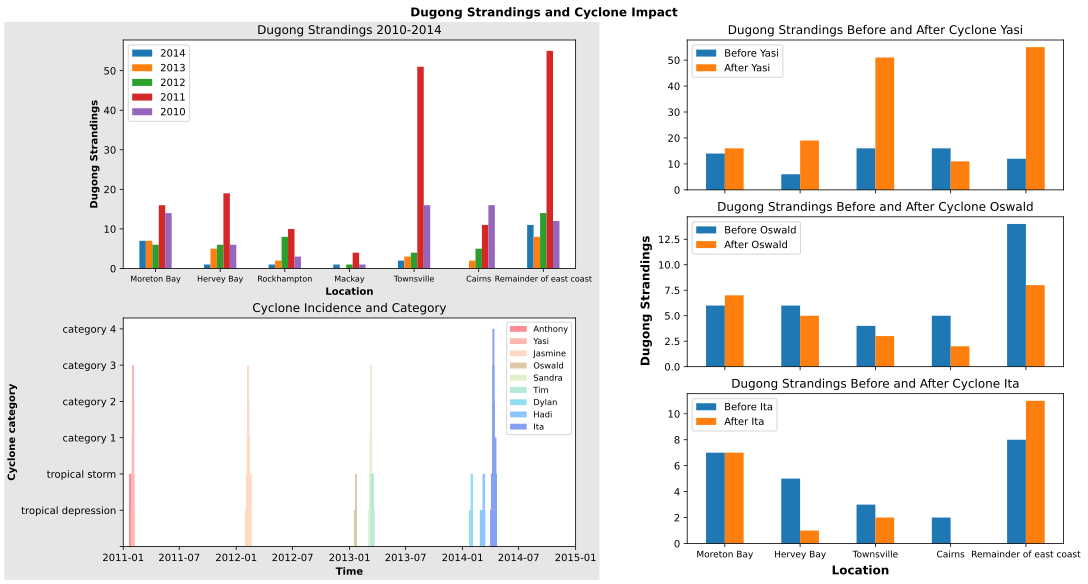

In [31]:
# Setting up a multi-panel figure with one row and two columns for our subfigures and setting width ratios of these columns
fig = plt.figure(layout="constrained", figsize=(15, 8))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2., 1.5])

# Adding two rows to plot in our first (left) subfigure column and setting the background colour to grey
axs0 = subfigs[0].subplots(2, 1)
subfigs[0].set_facecolor('0.9')

# Plotting dugong strandings in the first row of the left subfigure panel and adding a title and axis labels
axs0[0] = dugong.plot(ax=axs0[0], kind='bar')
axs0[0].set_title('Dugong Strandings 2010-2014')
axs0[0].set_xlabel('Location',weight='bold')
axs0[0].set_ylabel('Dugong Strandings', weight='bold')
axs0[0].set_xticklabels(axs0[0].get_xticklabels(), fontsize=8, rotation=0) 

# Plotting cyclone category at each recorded time with different bar colour for each cyclone
# This will be plotted in the second row of the left subfigure panel
axs0[1].bar(Anthony["ISO_TIME"], Anthony["CATEGORY"], color="#ff8b94", label='Anthony', align='center', width=5)
axs0[1].bar(Yasi["ISO_TIME"], Yasi["CATEGORY"], color="#FFB7B2", label='Yasi', align='center', width=5)
axs0[1].bar(Jasmine["ISO_TIME"], Jasmine["CATEGORY"], color="#FFDAC1", label='Jasmine', align='center', width=5)
axs0[1].bar(Oswald["ISO_TIME"], Oswald["CATEGORY"], color="#dfc7a7", label='Oswald', align='center', width=5)
axs0[1].bar(Sandra["ISO_TIME"], Sandra["CATEGORY"], color="#E2F0CB", label='Sandra', align='center', width=5)
axs0[1].bar(Tim["ISO_TIME"], Tim["CATEGORY"], color="#B5EAD7", label='Tim', align='center', width=5)
axs0[1].bar(Dylan["ISO_TIME"], Dylan["CATEGORY"], color="#91DDF2", label='Dylan', align='center', width=5)
axs0[1].bar(Hadi["ISO_TIME"], Hadi["CATEGORY"], color="#8BC6FC", label='Hadi', align='center', width=5)
axs0[1].bar(Ita["ISO_TIME"], Ita["CATEGORY"], color="#85A1F2", label='Ita', align='center', width=5)

# Setting the x-axis limit for the cyclone figure
axs0[1].set_xlim([datetime.date(2011, 1, 1), datetime.date(2015, 1, 1)])

# Setting axes labels, adding legend and title for the cyclone figure
axs0[1].set_ylabel("Cyclone category", weight='bold')
axs0[1].set_xlabel("Time", color="k", weight='bold')
axs0[1].legend(loc=1, fontsize='small')
axs0[1].set_title('Cyclone Incidence and Category')

# Now we will plot 3 subplots of cyclone impacts on dugong strandings which share the same x-axis 
# In the first row of the right subfigure panel, we plot the impact of cyclone Yasi on dugong strandings
axs1 = subfigs[1].subplots(3, 1, sharex=True)
axs1[0] = dugongYasi.plot(ax=axs1[0], kind='bar')
axs1[0].set_title('Dugong Strandings Before and After Cyclone Yasi')

# In the second row of the right subfigure panel, we plot the impact of cyclone Oswald on dugong strandings
axs1[1] = dugongOswald.plot(ax=axs1[1], kind='bar')
axs1[1].set_title('Dugong Strandings Before and After Cyclone Oswald')
axs1[1].set_title('Dugong Strandings Before and After Cyclone Oswald')

# In the third row of the right subfigure panel, we plot the impact of cyclone Ita on dugong strandings
axs1[2] = dugongIta.plot(ax=axs1[2], kind='bar')
axs1[2].set_title('Dugong Strandings Before and After Cyclone Ita')
axs1[2].set_xlabel('') # We set an empty label since we do not want to display this axis label

# Setting y and x labels to use for all the plots in the right panel
subfigs[1].supylabel('Dugong Strandings', weight='bold')
subfigs[1].supxlabel('Location', weight='bold')
plt.xticks(fontsize=9,rotation=0) 

# Setting the title of the entire multi-panel figure and saving the figure
fig.suptitle('Dugong Strandings and Cyclone Impact', weight='bold')
plt.savefig('Dugong Strandings and Cyclone Impact')